# CPSC 330 - Applied Machine Learning 

## Homework 8: Word embeddings, time series, and communication
### Associated lectures: Lectures 17, 19, 20, and ML communication 

**Due date: April 12, 2022 at 11:59pm**

## Table of Contents

- [Submission instructions](#sg) (4%)
- [Exercise 1 - Exploring pre-trained word embeddings](#1) (24%)
- [Exercise 2 - Exploring time series data](#2) (16%)
- [Exercise 3 - Short answer questions](#4) (10%)
- [Exercise 4 - Communication](#4) (46%)
- (Optional)[Exercise 5 - Course take away](#5)

In [217]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:4}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1:  Exploring pre-trained word embeddings <a name="1"></a>
<hr>

In lecture 17, we talked about natural language processing (NLP). Using pre-trained word embeddings is very common in NLP. It has been shown that pre-trained word embeddings [work well on a variety of text classification tasks](http://www.lrec-conf.org/proceedings/lrec2018/pdf/721.pdf). These embeddings are created by training a model like Word2Vec on a huge corpus of text such as a dump of Wikipedia or a dump of the web crawl. 

A number of pre-trained word embeddings are available out there. Some popular ones are: 

- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using the fastText algorithm
    * published by Facebook
    
In this exercise, you will be exploring GloVe Wikipedia pre-trained embeddings. The code below loads the word vectors trained on Wikipedia using an algorithm called Glove. You'll need `gensim` package for that in your cpsc330 conda environment. 

```
> conda activate cpsc330
> conda install -c anaconda gensim
```

In [2]:
import gensim
import gensim.downloader

print(list(gensim.downloader.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
# This will take a while to run when you run it for the first time.
import gensim.downloader as api

glove_wiki_vectors = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [4]:
len(glove_wiki_vectors)

400000

There are 400,000 word vectors in these pre-trained model. 

<br><br>

### 1.1 Word similarity using pre-trained embeddings
rubric={points:4}

Now that we have GloVe Wiki vectors (`glove_wiki_vectors`) loaded, let's explore the embeddings. 

**Your tasks:**

1. Calculate the cosine similarity for the following word pairs (`word_pairs`) using the [`similarity`](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) method of the model.
2. Do the similarities make sense? 

In [5]:
word_pairs = [
    ("coast", "shore"),
    ("clothes", "closet"),
    ("old", "new"),
    ("smart", "intelligent"),
    ("dog", "cat"),
    ("tree", "lawyer"),
]

In [15]:
similarities = {}
for p in word_pairs:
    similarities[p] = [glove_wiki_vectors.similarity(p[0], p[1])]

In [16]:
pd.DataFrame.from_dict(similarities)

,coast,clothes,old,smart,dog,tree
,shore,closet,new,intelligent,cat,lawyer
0,0.700027,0.546276,0.643249,0.755273,0.879807,0.076719


The similarities make some sense, as words that are closely associated e.g. coast/shore, or belonging to the same category e.g. dog/cat, have high similarity, and tree/lawyer, which are not very intuitively similar, have a low similarity. 

It is not very clear why e.g. dog/cat are more similar than coast/shore, however, so some details may make less sense.

<br><br>

### 1.2 Bias in embeddings
rubric={points:10}

**Your tasks:**
1. In Lecture 17 we saw that our pre-trained word embedding model output an analogy that reinforced a gender stereotype. Give an example of how using such a model could cause harm in the real world.
2. Here we are using pre-trained embeddings which are built using a dump of Wikipedia data. Explore whether there are any worrisome biases present in these embeddings or not by trying out some examples. You can use the following two methods or other methods of your choice to explore what kind of stereotypes and biases are encoded in these embeddings. 
    - You can use the `analogy` function below which gives words analogies. 
    - You can also use [similarity](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) or [distance](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=distance#gensim.models.keyedvectors.KeyedVectors.distances) methods. (An example is shown below.)   
3. Discuss your observations. Do you observe the gender stereotype we observed in class with GloVe Wikipedia embeddings?

> Note that most of the recent embeddings are de-biased. But you might still observe some biases in the embeddings. Also, not all stereotypes present in pre-trained embeddings are necessarily bad. But you should be aware of them when you use embeddings in your models. 

Answer 1: An example could be if we are using such a model to generate examples for a children's book to teach them about different careers. A biased model could be more likely to suggest male examples for professions such as doctors, engineers etc., and female examples for careers such as homemaker or lower-skilled professions. Children that learn from such examples could grow up with the bias that boys are more able to go into high-skill professions such as doctor and engineer.

In [17]:
def analogy(word1, word2, word3, model=glove_wiki_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

An example of using similarity between words to explore biases and stereotypes.  

In [18]:
glove_wiki_vectors.similarity("white", "rich")

0.447236

In [19]:
glove_wiki_vectors.similarity("black", "rich")

0.5174519

Answer 2: Trying out analogies below

*Profession bias*

In [34]:
analogy("man", "doctor", "woman", model=glove_wiki_vectors)

man : doctor :: woman : ?


,Analogy word,Score
0,nurse,0.773523
1,physician,0.718943
2,doctors,0.682433
3,patient,0.675068
4,dentist,0.672603
5,pregnant,0.664246
6,medical,0.652045
7,nursing,0.645348
8,mother,0.639333
9,hospital,0.638750


In [47]:
analogy("man", "nurse", "woman", model=glove_wiki_vectors)

man : nurse :: woman : ?


,Analogy word,Score
0,nurses,0.693047
1,nursing,0.678602
2,pregnant,0.674416
3,midwife,0.668430
4,dentist,0.642971
5,therapist,0.637525
6,pediatrician,0.625592
7,doctor,0.604205
8,physician,0.596565
9,mother,0.587298


*Field bias*

In [22]:
analogy("man", "mathematics", "woman", model=glove_wiki_vectors)

man : mathematics :: woman : ?


,Analogy word,Score
0,humanities,0.691818
1,sociology,0.688262
2,undergraduate,0.677993
3,biology,0.673875
4,physics,0.672595
5,sciences,0.664970
6,linguistics,0.655082
7,doctorate,0.647279
8,graduate,0.645335
9,phd,0.641917


In [23]:
analogy("man", "humanities", "woman", model=glove_wiki_vectors)

man : humanities :: woman : ?


,Analogy word,Score
0,sciences,0.684250
1,undergraduate,0.643098
2,faculty,0.621861
3,graduate,0.599129
4,mathematics,0.596956
5,sociology,0.594296
6,education,0.581553
7,academic,0.580922
8,fellowships,0.580897
9,arts,0.579545


*Intelligence bias*

In [25]:
analogy("man", "smart", "woman", model=glove_wiki_vectors)

man : smart :: woman : ?


,Analogy word,Score
0,intelligent,0.654885
1,sexy,0.597897
2,sophisticated,0.574362
3,mom,0.557256
4,cute,0.549813
5,kids,0.540299
6,pretty,0.530862
7,savvy,0.530233
8,innovative,0.530197
9,attractive,0.528517


Bias in similarities examined below:

In [35]:
glove_wiki_vectors.similarity("man", "intelligent")

0.4394357

In [36]:
glove_wiki_vectors.similarity("woman", "intelligent")

0.37589207

In [42]:
glove_wiki_vectors.similarity("europe", "good")

0.46739095

In [43]:
glove_wiki_vectors.similarity("africa", "good")

0.39018187

In [45]:
glove_wiki_vectors.similarity("europe", "wild")

0.33578396

In [44]:
glove_wiki_vectors.similarity("africa", "wild")

0.3709802

In [48]:
glove_wiki_vectors.similarity("white", "crime")

0.38129756

In [49]:
glove_wiki_vectors.similarity("black", "crime")

0.43576178

I observe some bias in this model. For example, it outputs that man:doctor as woman:nurse. This cannot be merely a product of the phrasing of the question, as when reversed it outputs that man:nurse as women:nurses. It is therefore heavily biased towards women being nurses while men are doctors.

This bias does no carry over to some areas, e.g. man:mathematics is as woman:humanities, which appears biased, but reversed gives man:humanities as woman:sciences. This may therefore only be a product of the way the question is phrased (forcing the model to choose a complementary field to the first one).

For an analogy between man:smart and woman:?, the function outputs 'intelligent' as the top answer, which does not appear to biased. However, close behind is the second option, 'sexy', which may show a bias in the model to sometimes consider women's value to be in attractiveness whereas men's is in their intelligence.

There are some biases apparent through the similarity measures; e.g. 'man' is closer to 'intelligent' than 'woman' is, and 'black' is closer to 'crime' than 'white' is. These differences are not very large, so they may not indicate a bias that would come up dangerously when deployed.

<br><br>

### 1.3 Representation of all words in English
rubric={reasoning:2}

**Your tasks:**
1. The vocabulary size of Wikipedia embeddings is quite large. Do you think it contains **all** words in English language? What would happen if you try to get a word vector that's not in the vocabulary (e.g., "cpsc330"). 

Answer: It is unlikely to contain all the words in the English language, as there are many niche words in topics that may not be discussed on Wikipedia, as well as new words always being added.You would likely get an error if you try to get a word vector that's not in the vocabulary.

<br><br>

### 1.4 Classification with pre-trained embeddings
rubric={points:8}

In lecture 16, we saw that you can conveniently get word vectors with `spaCy` with `en_core_web_md` model. In this exercise, you'll use word embeddings in multi-class text classification task. We will use [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus which contains about 100,000 happy moments classified into 7 categories: *affection, exercise, bonding, nature, leisure, achievement, enjoy_the_moment*. The data was crowd-sourced via [Amazon Mechanical Turk](https://www.mturk.com/). The ground truth label is not available for all examples, and in this lab, we'll only use the examples where ground truth is available (~15,000 examples). 

- Download the data from [here](https://www.kaggle.com/ritresearch/happydb).
- Unzip the file and copy it in the lab directory.

The code below reads the data CSV (assuming that it's present in the current directory as *cleaned_hm.csv*),  cleans it up a bit, and splits it into train and test splits. 

**Your tasks:**

1. Train a logistic regression with bag-of-words features and show the classification report on the test set. 
2. Train logistic regression with average embedding representation extracted using spaCy and classification report on the test set. (You can refer to lecture 17 notes for this. Hint: you may want to consider using different [solvers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if you see convergence issues).  
3. Discuss your results. Which model would be more interpretable?  
4. Are you observing any benefits of transfer learning here? Briefly discuss. 

In [52]:
df = pd.read_csv("cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()

,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed after a long time.,My grandmother start to walk from the bed after a long time.,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding


In [53]:
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)

In [54]:
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
X_train, y_train = train_df["moment"], train_df["target"]
X_test, y_test = test_df["moment"], test_df["target"]

In [57]:
import spacy

nlp = spacy.load("en_core_web_md")

**1. Logistic regression with bag-of-words features**

Train a logistic regression with bag-of-words features and show the classification report on the test set.

In [107]:
#Code based on lecture 17

pipe_bow = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000)
)
pipe_bow.named_steps["countvectorizer"].fit(X_train)
X_train_bow = pipe_bow.named_steps["countvectorizer"].transform(X_train)
#print("Data matrix shape:", X_train_bow.shape)
pipe_bow.fit(X_train, y_train);

In [108]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pipe_bow.predict(X_test)))

                  precision    recall  f1-score   support

     achievement       0.79      0.87      0.83      1302
       affection       0.90      0.91      0.91      1423
         bonding       0.91      0.85      0.88       492
enjoy_the_moment       0.60      0.54      0.57       469
        exercise       0.91      0.57      0.70        74
         leisure       0.73      0.70      0.71       407
          nature       0.73      0.46      0.57        71

        accuracy                           0.82      4238
       macro avg       0.80      0.70      0.74      4238
    weighted avg       0.82      0.82      0.81      4238



**2. Logistic regression with average embedding representation**

Train logistic regression with average embedding representation extracted using spaCy and classification report
on the test set. (You can refer to lecture 17 notes for this. Hint: you may want to consider using different 
solvers if you see convergence issues).

In [109]:
#Code based on lecture 17

X_train_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_train)])
X_test_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_test)])

In [116]:
lgr = LogisticRegression(max_iter=10000)#very high
lgr.fit(X_train_embeddings, y_train)
print("Test accuracy {:.2f}".format(lgr.score(X_test_embeddings, y_test)))

Test accuracy 0.79


In [118]:
print(classification_report(y_test, lgr.predict(X_test_embeddings)))

                  precision    recall  f1-score   support

     achievement       0.81      0.83      0.82      1302
       affection       0.86      0.91      0.89      1423
         bonding       0.83      0.77      0.80       492
enjoy_the_moment       0.57      0.51      0.53       469
        exercise       0.68      0.76      0.72        74
         leisure       0.72      0.65      0.68       407
          nature       0.68      0.72      0.70        71

        accuracy                           0.79      4238
       macro avg       0.74      0.74      0.73      4238
    weighted avg       0.79      0.79      0.79      4238



*3. Discuss your results. Which model would be more interpretable?*

The model with the bag-of-words features are more interpretable since the coefficients are of each word. The larger the coeffcient, the more important that word is to predicting the positive class. 

The model with the average embedding representation are learning the coefficient from arbitrary features that consists of the word vectors.

The first model has better precision and f1 score than the second model, though their recall is similar. It is also more interpretable, as it uses bag-of-words.

*4. Are you observing any benefits of transfer learning here? Briefly discuss.*

Not much, as the embeddings only perform about as well, or even a little worse, than bag of words when predicting on the test set.

<br><br><br><br>

## Exercise 2: Exploring time series data <a name="2"></a>
<hr>

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. 

In [120]:
df = pd.read_csv("avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [121]:
df.shape

(18249, 13)

In [122]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [123]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~5 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [125]:
split_date = "20170925"
train_df = df[df["Date"] <= split_date]
test_df = df[df["Date"] > split_date]

In [126]:
assert len(train_df) + len(test_df) == len(df)

### 2.1
rubric={points:4}

In the Rain in Australia dataset from lecture, we had different measurements for each Location. What about this dataset: for which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

In [197]:
print("Total rows:", len(df["Date"]), ", Unique dates:", len(df["Date"].unique()))

Total rows: 18249 , Unique dates: 169


In [203]:
from datetime import datetime, timedelta

def find(lst, a):
    return [i for i, x in enumerate(lst) if x==a]

In [216]:
first_repeats = find(df["Date"], df["Date"].iloc[0])
repeats_df=pd.DataFrame(columns = df.columns)
for i in first_repeats:
    repeats_df.loc[len(repeats_df.index)] = (df.iloc[i])
repeats_df

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-27,0.99,386100.49,292097.36,27350.92,297.9,66354.31,48605.95,17748.36,0.0,conventional,2015,Atlanta
2,2015-12-27,1.17,596819.4,40450.49,394104.02,17353.79,144911.1,142543.88,2367.22,0.0,conventional,2015,BaltimoreWashington
3,2015-12-27,0.97,62909.69,30482.25,2971.94,5894.4,23561.1,23520.19,5.69,35.22,conventional,2015,Boise
4,2015-12-27,1.13,450816.39,3886.27,346964.7,13952.56,86012.86,85913.6,99.26,0.0,conventional,2015,Boston
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2015-12-27,1.54,1652.19,0.0,73.22,0.0,1578.97,1336.27,242.7,0.0,organic,2015,Syracuse
104,2015-12-27,1.63,2161.84,874.75,17.54,0.0,1269.55,1216.67,52.88,0.0,organic,2015,Tampa
105,2015-12-27,1.52,549787.59,89709.92,206198.62,5836.04,248043.01,142262.93,105780.08,0.0,organic,2015,TotalUS
106,2015-12-27,1.46,142710.36,29880.32,48416.71,38.63,64374.7,17464.54,46910.16,0.0,organic,2015,West


In [218]:
repeats_df["type"].value_counts()

conventional    54
organic         54
Name: type, dtype: int64

Answer: It appears, from looking at all the different measurements for a single date, that there are different measurements for each **type** (conventional/organic) and for each **region**.

<br><br>

### 2.2
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

In [220]:
from datetime import datetime, timedelta

for i in range(len(df["Date"])-1):
    if ((df["Date"].iloc[i] - df["Date"].iloc[i+1]) != timedelta(days=7)) & (df["region"].iloc[i] == df["region"].iloc[i+1]):
        print("i = ", i, "Gap = ", (df["Date"].iloc[i] - df["Date"].iloc[i+1]))
        

i =  11884 Gap =  14 days 00:00:00
i =  17576 Gap =  21 days 00:00:00


In [223]:
pd.DataFrame(data = [df.iloc[11884], df.iloc[11885]], index=[1,2])

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
1,2015-12-13,1.80,7836.65,2194.49,2981.01,25.97,2635.18,2598.45,36.73,0.0,organic,2015,WestTexNewMexico
2,2015-11-29,2.08,4638.10,1395.02,2238.04,61.71,943.33,943.33,0.00,0.0,organic,2015,WestTexNewMexico


In [224]:
pd.DataFrame(data = [df.iloc[17576], df.iloc[17577]], index=[1,2])

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
1,2017-07-02,1.59,20486.25,2454.99,3470.63,0.0,14560.63,10390.44,4170.19,0.0,organic,2017,WestTexNewMexico
2,2017-06-11,1.66,21170.11,3042.11,3588.46,0.0,14539.54,7757.19,6782.35,0.0,organic,2017,WestTexNewMexico


The measurements seem to be equally spaced at 7 days apart for each region, except at two places (between rows 11884 and 11885 = 14 days, and rows 17576 and 17577 = 21 days) where perhaps one or two measurements were skipped.

<br><br>

### 2.3
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are all distinct, or are there overlapping regions? Justify your answer by referencing the data.

In [185]:
df["region"].value_counts()

Albany                 338
Sacramento             338
Northeast              338
NorthernNewEngland     338
Orlando                338
Philadelphia           338
PhoenixTucson          338
Pittsburgh             338
Plains                 338
Portland               338
RaleighGreensboro      338
RichmondNorfolk        338
Roanoke                338
SanDiego               338
Atlanta                338
SanFrancisco           338
Seattle                338
SouthCarolina          338
SouthCentral           338
Southeast              338
Spokane                338
StLouis                338
Syracuse               338
Tampa                  338
TotalUS                338
West                   338
NewYork                338
NewOrleansMobile       338
Nashville              338
Midsouth               338
BaltimoreWashington    338
Boise                  338
Boston                 338
BuffaloRochester       338
California             338
Charlotte              338
Chicago                338
C

There may be some overlap, e.g. the region 'TotalUS' likely encompasses all the regions in the US. There are also some relatively vague region names such as 'West' and 'South' which may encompass all the regions in those areas.

<br><br><br><br>

## Preparation for models

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We would like to forecast the avocado price, which is the `AveragePrice` column. The function below is adapted from Lecture 19, with some improvements.

In [186]:
def create_lag_feature(
    df, orig_feature, lag, groupby, new_feature_name=None, clip=False
):
    """
    Creates a new feature that's a lagged version of an existing one.

    NOTE: assumes df is already sorted by the time columns and has unique indices.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature

    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.

    TODO: could/should simplify this function by using `df.shift()`
    """

    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)

    new_df = df.assign(**{new_feature_name: np.nan})
    for name, group in new_df.groupby(groupby):
        if lag < 0:  # take values from the past
            new_df.loc[group.index[-lag:], new_feature_name] = group.iloc[:lag][
                orig_feature
            ].values
        else:  # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][
                orig_feature
            ].values

    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])

    return new_df

We first sort our dataframe properly:

In [187]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [225]:
df_hastarget = create_lag_feature(
    df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True
)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


I will now split the data:

In [318]:
train_df = df_hastarget[df_hastarget["Date"] <= split_date]
test_df = df_hastarget[df_hastarget["Date"] > split_date]

<br><br>

### 2.4 Baseline
rubric={points:4}

Let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse than this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get?

In [ ]:
#Checking for NAs
pd.DataFrame(data = [train_df.isna().sum(), test_df.isna().sum()])

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [233]:
#Split into X and y
X_train = train_df.drop(columns = ["AveragePriceNextWeek"])
y_train = train_df["AveragePriceNextWeek"]
X_test = test_df.drop(columns = ["AveragePriceNextWeek"])
y_test = test_df["AveragePriceNextWeek"]

In [234]:
def baseline_forecast(df):
    return df["AveragePrice"]

In [240]:
print("R^2 with train data: {:.2f}".format(r2_score(y_train, baseline_forecast(X_train))))
print("R^2 with test data: {:.2f}".format(r2_score(y_test, baseline_forecast(X_test))))

R^2 with train data: 0.83
R^2 with test data: 0.76


<br><br>

### (Optional) 2.5 Modeling
rubric={points:2}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

> because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

In [293]:
ohe_feature_names = (
    preprocessor.named_transformers_["onehotencoder"]
    .get_feature_names()
    .tolist()
)
new_columns = numeric_features + ohe_feature_names + passthrough_features

preprocessor.transform(train_df_posix)

#X_train_enc = pd.DataFrame(
 #   preprocessor.transform(train_df), index=train_df.index, columns=new_columns
#)

C:\Users\rikib\miniconda3\envs\cpsc330\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[ 0.00000000e+00, -4.32512311e-01, -2.34534593e-01, ...,
         0.00000000e+00,  0.00000000e+00,  2.01500000e+03],
       [ 0.00000000e+00, -3.83675762e-01, -2.34440329e-01, ...,
         0.00000000e+00,  0.00000000e+00,  2.01500000e+03],
       [ 0.00000000e+00, -5.54603686e-01, -2.33468919e-01, ...,
         0.00000000e+00,  0.00000000e+00,  2.01500000e+03],
       ...,
       [ 0.00000000e+00,  2.40000758e+00, -2.43034198e-01, ...,
         0.00000000e+00,  1.00000000e+00,  2.01700000e+03],
       [ 0.00000000e+00,  2.35117103e+00, -2.43442253e-01, ...,
         0.00000000e+00,  1.00000000e+00,  2.01700000e+03],
       [ 0.00000000e+00,  2.10698828e+00, -2.43716331e-01, ...,
         0.00000000e+00,  1.00000000e+00,  2.01700000e+03]])

In [291]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
        ("passthrough", passthrough_features),
    )
preprocessor.fit(train_df_posix)


ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['Date', 'AveragePrice', 'Total Volume',
                                  '4046', '4225', '4770', 'Total Bags',
                                  'Small Bags', 'Large Bags', 'XLarge Bags']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['type', 'region']),
                                ('drop', 'drop', ['AveragePriceNextWeek']),
                                ('passthrough', 'passthrough', ['year'])])

In [294]:
#code based on lecture 19

def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    passthrough_features,
    drop_features
):

    all_features = set(numeric_features + categorical_features + passthrough_features + drop_features)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

    preprocessor = make_column_transformer(
            (numeric_transformer, numeric_features),
            (categorical_transformer, categorical_features),
            ("drop", drop_features),
            ("passthrough", passthrough_features),
        )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["onehotencoder"]
        .get_feature_names()
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names + passthrough_features

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), columns=new_columns
    )#index=train_df.index,
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), columns=new_columns
    )#, index=test_df.index

    y_train = train_df["AveragePriceNextWeek"]
    y_test = test_df["AveragePriceNextWeek"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [270]:
numeric_features = ['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
categorical_features= ['type', 'region']
passthrough_features = ['year']
drop_features = ['AveragePriceNextWeek']

Trying Random Forest (with POSIX date format):

In [273]:
def dates_to_POSIX(data):
    date = data["Date"]
    for d in date:
        d = d.timestamp()
    df = data.copy()
    df["Date"] = d
    return df

In [261]:
train_df_posix = dates_to_POSIX(train_df)
test_df_posix = dates_to_POSIX(test_df)

In [295]:
X_train_enc_posix, y_train, X_test_enc_posix, y_test, preprocessor = preprocess_features(
    train_df_posix,
    test_df_posix,
    numeric_features,
    categorical_features,
    passthrough_features,
    drop_features
)

C:\Users\rikib\miniconda3\envs\cpsc330\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [301]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train_enc_posix, y_train)

R^2 with train data: 0.98


In [303]:
print("R^2 with train data: {:.2f}".format(regressor.score(X_train_enc_posix, y_train)))
print("R^2 with test data: {:.2f}".format(regressor.score(X_test_enc_posix, y_test)))

R^2 with train data: 0.98
R^2 with test data: 0.76


Trying Ridge Regression (with POSIX time)

In [306]:
from sklearn.linear_model import Ridge

linregressor = Ridge()
linregressor.fit(X_train_enc_posix, y_train)

Ridge()

In [307]:
print("R^2 with train data: {:.2f}".format(linregressor.score(X_train_enc_posix, y_train)))
print("R^2 with test data: {:.2f}".format(linregressor.score(X_test_enc_posix, y_test)))

R^2 with train data: 0.85
R^2 with test data: 0.79


One-hot encoding month and seasons

In [311]:
#code from lecture 19
def get_season(month):
    WINTER_MONTHS = ["June", "July", "August"]
    AUTUMN_MONTHS = ["March", "April", "May"]
    SUMMER_MONTHS = ["December", "January", "February"]
    SPRING_MONTHS = ["September", "October", "November"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Fall"

In [319]:
# based on lecture 19
train_df_month = train_df.assign(Month=train_df["Date"].apply(lambda x: x.month_name()))
test_df_month = test_df.assign(Month=test_df["Date"].apply(lambda x: x.month_name()))
train_df_season = train_df_month.assign(Season=train_df_month["Month"].apply(get_season))
test_df_season = test_df_month.assign(Season=test_df_month["Month"].apply(get_season))

In [327]:
x = [1,2,3]

x.remove(2)

In [331]:
num = [n for n in numeric_features if n != "Date"]
X_train_enc_season, y_train, X_test_enc_season, y_test, preprocessor = preprocess_features(
    train_df_season,
    test_df_season,
    num,
    categorical_features + ["Month", "Season"],
    passthrough_features,
    drop_features + ["Date"]
)

C:\Users\rikib\miniconda3\envs\cpsc330\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Trying Random Forest with month+season

In [333]:
regressor_rf_2 = RandomForestRegressor(n_estimators=100, random_state=0)
regressor_rf_2.fit(X_train_enc_season, y_train)

RandomForestRegressor(random_state=0)

In [336]:
print("R^2 with train data: {:.2f}".format(regressor_rf_2.score(X_train_enc_season, y_train)))
print("R^2 with test data: {:.2f}".format(regressor_rf_2.score(X_test_enc_season, y_test)))

R^2 with train data: 0.98
R^2 with test data: 0.77


Trying Ridge with month+season

In [337]:
linregressor2 = Ridge()
linregressor2.fit(X_train_enc_season, y_train)

Ridge()

In [339]:
print("R^2 with train data: {:.2f}".format(linregressor2.score(X_train_enc_season, y_train)))
print("R^2 with test data: {:.2f}".format(linregressor2.score(X_test_enc_season, y_test)))

R^2 with train data: 0.85
R^2 with test data: 0.80


**Results**

THe approaches used involved two ways of encoding time (POSIX vs month+season) and two types of models (RF and Ridge). Overall, there were 4 approaches. The test scores for each are below.

Test scores (R^2):
- Random forest with POSIX time: 0.76
- Ridge regression with POSIX time: 0.79
- Random forest with month/season: 0.77
- Ridge regression with month/season: 0.80


Both model types performed very similarly for each type of time encoding, with only a 0.1 increase in score for month/season vs POSIX time. Ridge regression appeared to do better than RF for each type of time encoding (RF seemed to be overfitting to the training data). Overall, the best approach seems to be to use Ridge regression with month/season encoding.



<br><br><br><br>

## Exercise 3: Short answer questions <a name="3"></a>

Each question is worth 2 points.

### 3.1
rubric={points:4}

The following questions pertain to Lecture 18 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.

<br><br>

### 3.2
rubric={points:6}

The following questions pertain to Lecture 19 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques, as we did in hw4?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer?
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

<br><br><br><br>

## Exercise 4: Communication <a name="4"></a>
<hr>

### Exercise 4.1 Blog post 
rubric={points:40}

Write up your analysis from hw6 or any other assignment or your side machine learning related project in a "blog post" or report format. **You can write the post in Markdown in the notebook**, no need to write a real blog post (though you can if you want too!).

The target audience for your blog post is someone like yourself right before you took this course. They don't necessarily have ML knowledge, but they have a solid foundation in technical matters. The post should focus on explaining **your results and what you did** in a way that's understandable to such a person, **not** a lesson trying to teach someone about machine learning. Again: focus on the results and why they are interesting; avoid pedagogical content.

Your post must include the following elements (not necessarily in this order):

- Description of the problem/decision.
- Description of the dataset (the raw data and/or some EDA).
- Description of the model.
- Description your results, both quantitatively and qualitatively. Make sure to refer to the original problem/decision.
- A section on caveats, describing at least 3 reasons why your results might be incorrect, misleading, overconfident, or otherwise problematic. Make reference to your specific dataset, model, approach, etc. To check that your reasons are specific enough, make sure they would not make sense, if left unchanged, to most students' submissions; for example, do not just say "overfitting" without explaining why you might be worried about overfitting in your specific case.
- At least 3 visualizations. These visualizations must be embedded/interwoven into the text, not pasted at the end. The text must refer directly to each visualization. For example "as shown below" or "the figure demonstrates" or "take a look at Figure 1", etc. It is **not** sufficient to put a visualization in without referring to it directly.

A reasonable length for your entire post would be **800 words**. The maximum allowed is **1000 words**.

#### Example blog posts

Here are some examples of applied ML blog posts that you may find useful as inspiration. The target audiences of these posts aren't necessarily the same as yours, and these posts are longer than yours, but they are well-structured and engaging. You are **not required to read these** posts as part of this assignment - they are here only as examples if you'd find that useful.

From the UBC Master of Data Science blog, written by a past student:

- https://ubc-mds.github.io/2019-07-26-predicting-customer-probabilities/

This next one uses R instead of Python, but that might be good in a way, as you can see what it's like for a reader that doesn't understand the code itself (the target audience for your post here):

- https://rpubs.com/RosieB/taylorswiftlyricanalysis

Finally, here are a couple interviews with winners from Kaggle competitions. The format isn't quite the same as a blog post, but you might find them interesting/relevant:

- https://medium.com/kaggle-blog/instacart-market-basket-analysis-feda2700cded
- https://medium.com/kaggle-blog/winner-interview-with-shivam-bansal-data-science-for-good-challenge-city-of-los-angeles-3294c0ed1fb2


#### A note on plagiarism

You may **NOT** include text or visualizations that were not written/created by you. If you are in any doubt as to what constitutes plagiarism, please just ask. For more information see the [UBC Academic Misconduct policies](http://www.calendar.ubc.ca/vancouver/index.cfm?tree=3,54,111,959). Please don't copy this from somewhere 🙏. If you can't do it.

### **Predicting Customer Churn**

Customers cancelling reservations after they've already made them can be a big problem for hotels. It makes it hard to predict revenue, keep track of bookings, and can lead to the hotel losing money! In this post, we'll be discussing the results of trying to predict if a customer is likely to cancel their reservation, given some details about them and their booking.

We will first discuss the dataset we used, then some exploratory analysis of the dataset, feature engineering and preprocessing, and finally the different models we tried and their results.

### The Dataset

We used the **Reservation Cancellation Prediction** dataset from Kaggle. This dataset includes details about each customer's booking, such as number of adults, number of children, room type, number of previous cancellations, and more. For the full list have a look at [the Kaggle page](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). 

### Exploration (EDA)

The dataset has a mix of numerical, categorical, and binary features, which need to be preprocessed before being used for prediction. Their distributions can be seen below:

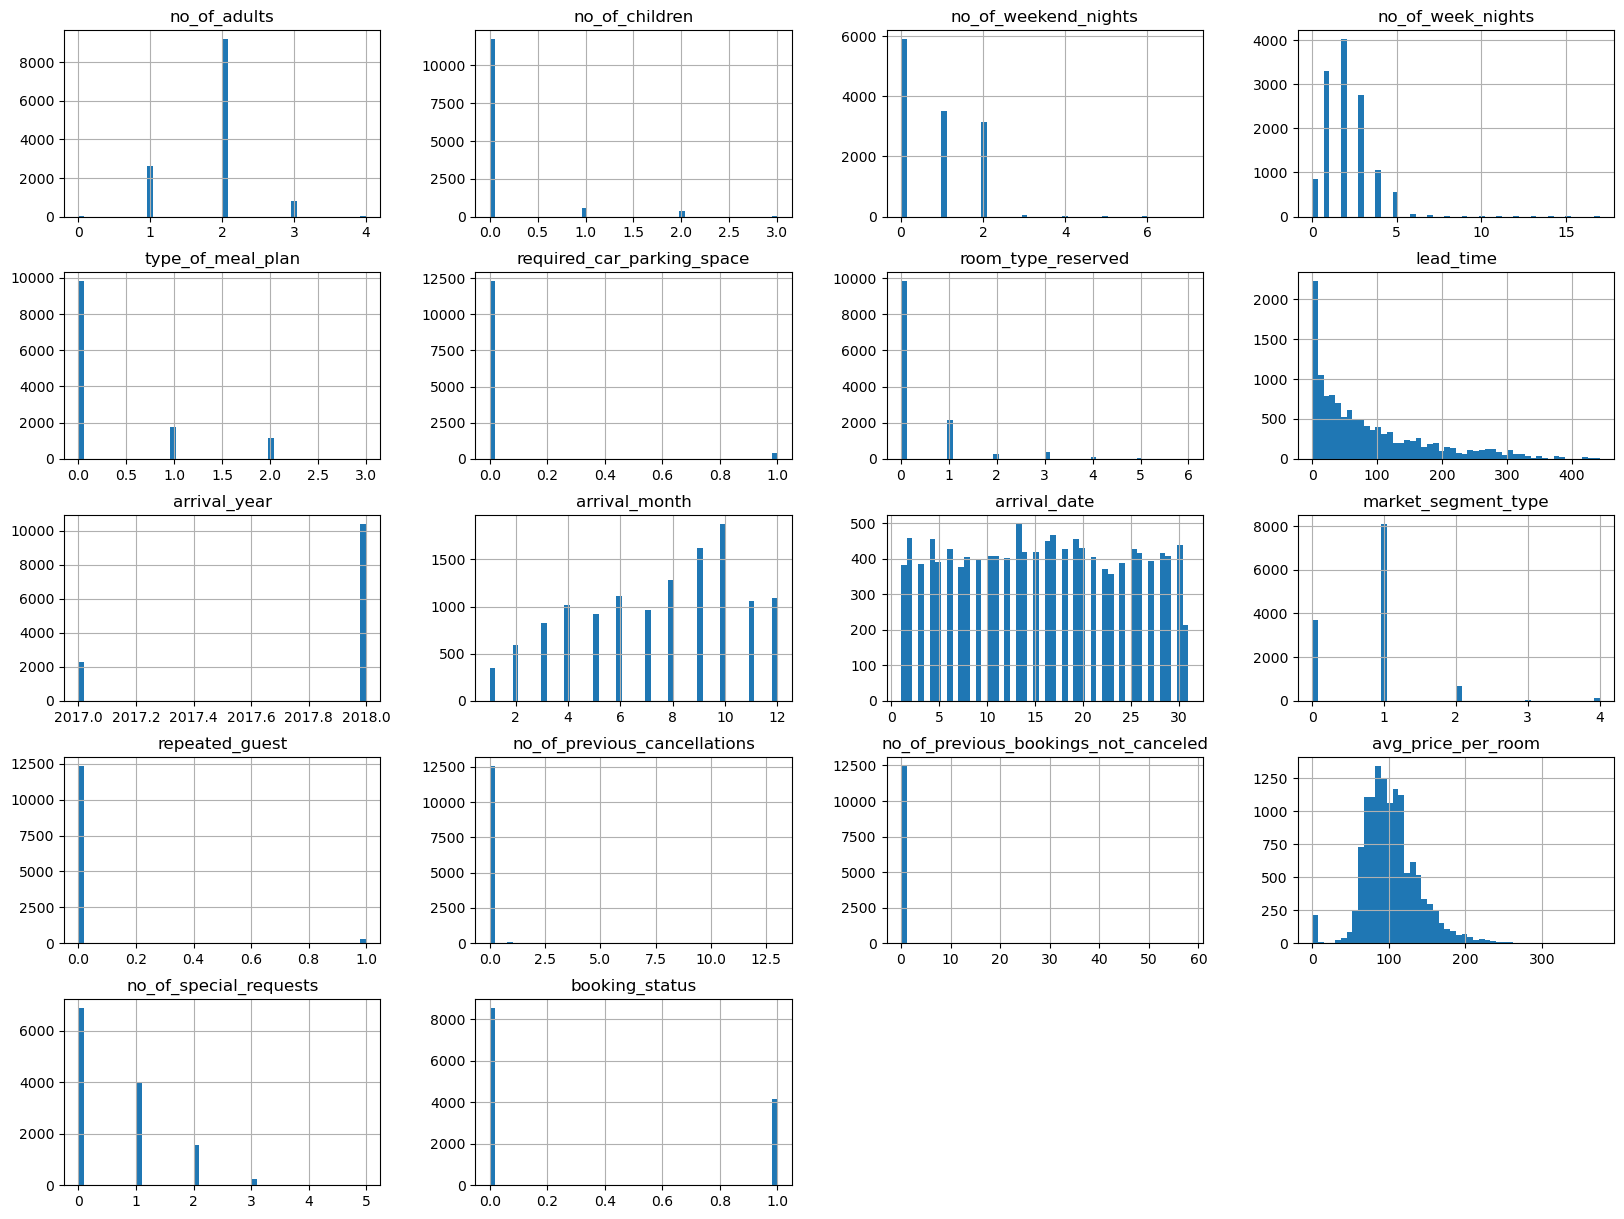
We can look at the correlations between all the different features; this can help us understand how different features might interact.

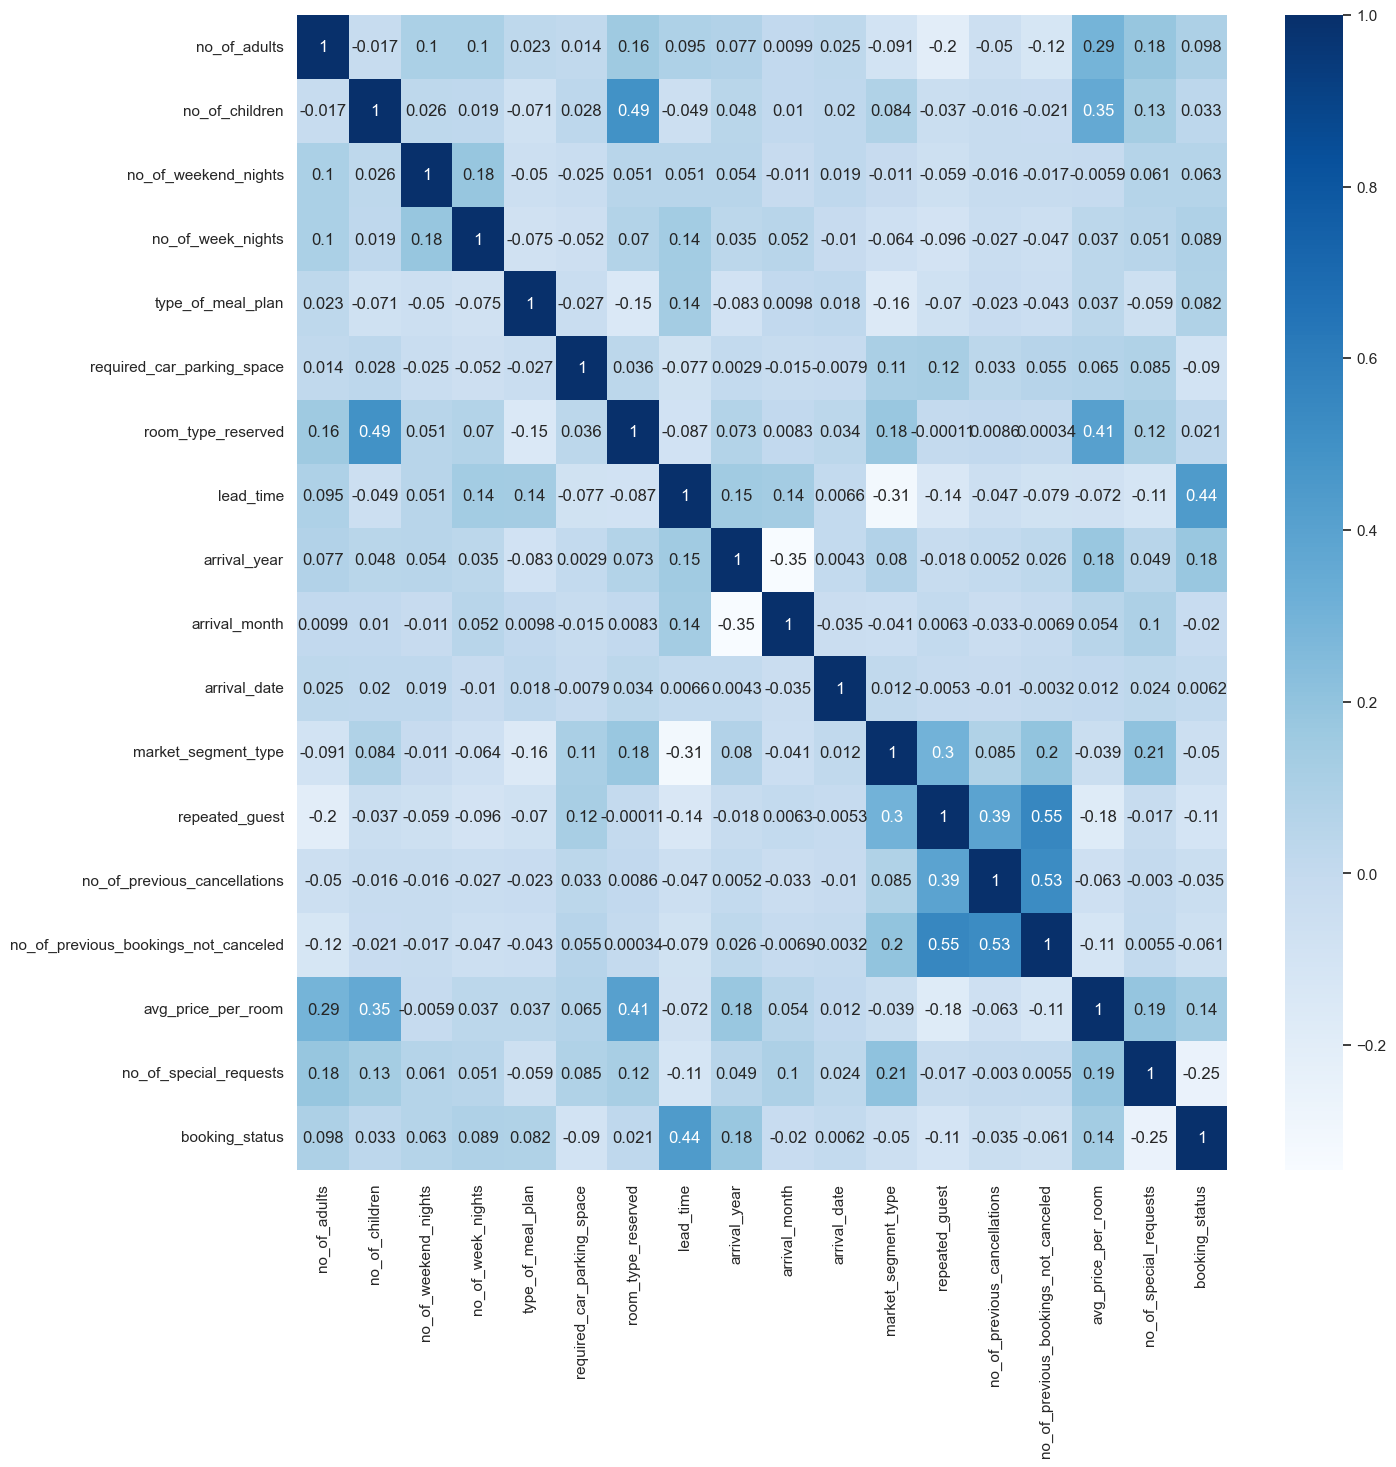

Interestingly, there seems to be a fairly high positive correlation between 'lead time' (number of days between the date of booking and the arrival date) and booking status being = 1. TO understand their interaction better, we can look at the distribution of lead time, split by booking status:

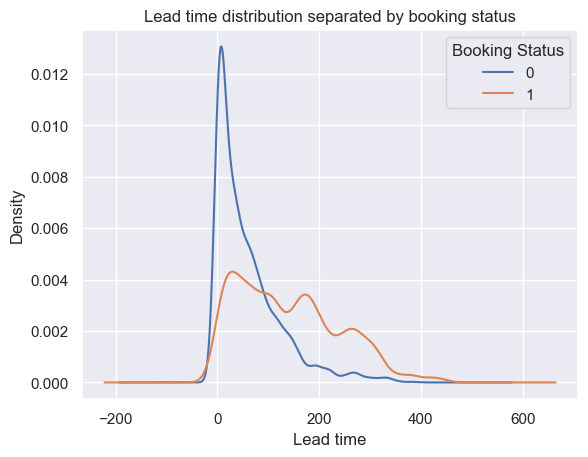

Lead time for those with booking status = 1 (i.e. they cancelled their booking) seems to be high more often than for those with booking status = 0.

### Feature engineering

We created some features using the ones we already had in the dataset, transforming them in ways we thought might be useful for our task.

First, we focused on lead times. From our exploration above, it seems that larger lead times are related to higher probability of cancellation. It is possible that this relationship is not linear, however; it may be sublinear, as it is possible the efect would decrease over time. This could be modelled with a log relationship, so we added a 'log_lead_time' feature using the 'pseudoLog' transformation (read about the details [here](https://win-vector.com/2012/03/01/modeling-trick-the-signed-pseudo-logarithm/)).

Next, we made binary variables to encode for whether there children in the booking, and whether there were adults in the booking - just in case focusing on the number of children or adults was not as important as if there were any or not.

Finally, we added a categorical version of arrival date that separated it into the beginning, middle or end of the month, in an effort to extract information from it that wasn't just the date.


### Preprocessing

We standardised all the numerical features, so they could be compared regardless of the units they were encode in. We also used one-hot-encoding on the categorical variables (i.e. turned them into a series of binary columns which each encoded for each category). As there were no missing values, we did not need to carry out any imputation.

### Models

**Baseline**
We first tried scikit-learn's baseline model. As it is predicting the most frequent class, it always predicts a negative. Accuracy is around 67%.

**Linear model**
Next we tried logistic regression, which is a simple, frequently used model with relatively high performaance. Logistic regression, after tuning the hyperparameters, had an accuracy of 81%, and at a threshold of 0.5, it has a recall of 64% and precision of 73%. The PR curve below shows the tradeoff between recall and precision at different thresholds for this model, and it shows that unfortunately having a high recall would require a fairly low precision.

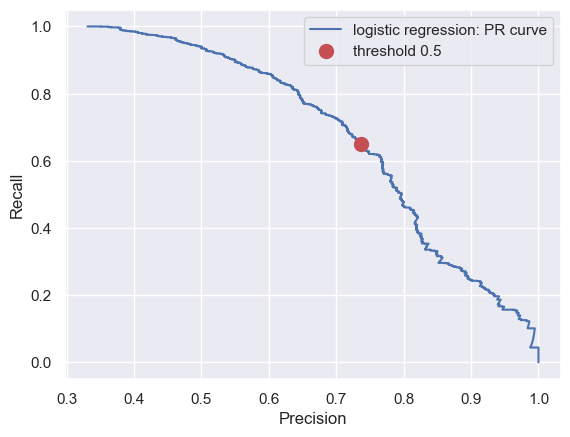

**Ensembles**
Ensemble methods train multiple models and then aggregate their scores, often resuling in better predictions than a single model. We tried three tree-based ensemble models: random forest, CatBoost, and LightGBM. They all usually perform similarly, with slightly different trade-offs in training time and performance. Their results for this task are below.

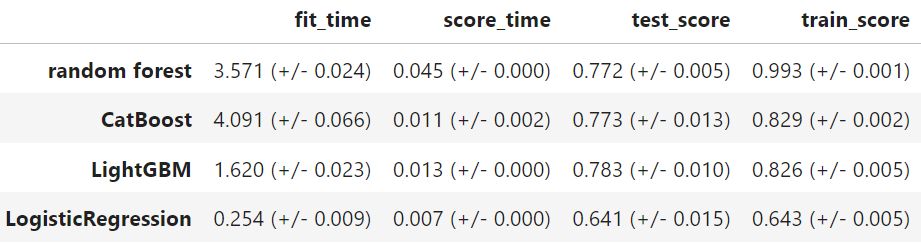

All of them do better than logistic regression; LightGBM does the best of all.

### Feature Interpretation

LightGBM appears to be doing the best overall - but what exactly is it doing? We used the SHAP package do investigate which features contributed the most to the model's predictions.

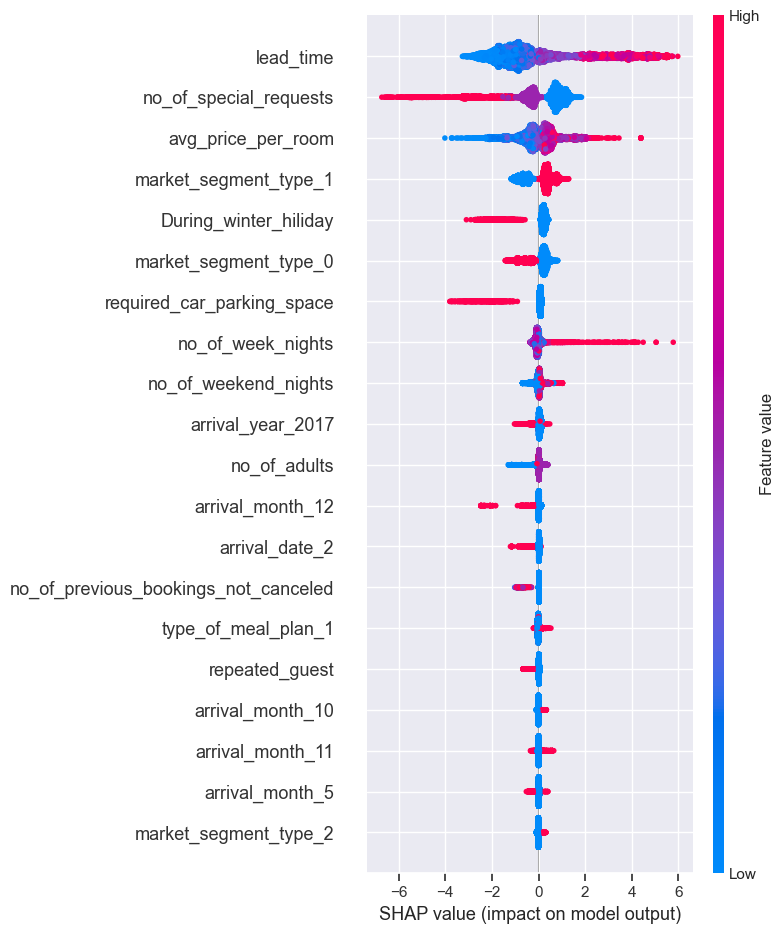

Based on the SHAP values, lead_time has the biggest impact on the model output: the more days there are between the date of booking and the arrival date, the bigger chance the room will be cancelled. The no_of_special_requests also has a big SHAP value, and from the graph we can see that the more special requests are made in the reservation, the more likely the room will not be cancelled.

### Conclusion

Overall, building an ensemble model with LightGBM allowed us to predict which customers would cancel their bookings fairly well. Our engineered features were not very important in the model, so they likely did not contribute much. A hotel could train a similar model on their data, with some simple preprocessing, and be able to save money by predicting cancellations.

<br><br>

### Exercise 4.2
rubric={points:6}

Describe one effective communication technique that you used in your post, or an aspect of the post that you are particularly satisfied with.

Max 3 sentences

Answer: I am satisified with the various visualisations I included in the post, as I feel the visual displays of the results are much more engaging for a reader than large blocks of text.

<br><br><br><br>

### (Optional) Exercise 5 <a name="5"></a>
rubric={points:1}

**Your tasks:**

What is your biggest takeaway from this course? 

> I'm looking forward to read your answers. 

Answer: There are lots of different sub-areas under machine learning!

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

### Congratulations on finishing all homework assignments! :clap: :clap: 

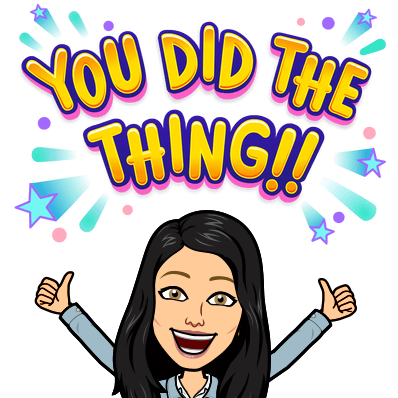

In [57]:
from IPython.display import Image

Image("eva-congrats.png")